In [1]:
import pandas as pd
import numpy as np
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy.optimize import minimize
from tqdm import tqdm
from xgboost import XGBRegressor
import copy
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

In [2]:
#data
train=pd.read_csv("dataset/train_features.csv")
y=pd.read_csv("dataset/train_labels.csv")
test=pd.read_csv("dataset/test_features.csv")
ss=pd.read_csv("dataset/submission_format.csv")

In [3]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [4]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [6]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [7]:
merged_df["year"]

0       2021
1       2021
2       2016
3       2021
4       2021
        ... 
4338    2021
4339    2016
4340    2021
4341    2021
4342    2021
Name: year, Length: 4343, dtype: int64

In [8]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [9]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

In [10]:
merged_test["year"]

0       2016
1       2016
2       2021
3       2016
4       2021
        ... 
1100    2016
1101    2021
1102    2016
1103    2021
1104    2021
Name: year, Length: 1105, dtype: int64

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

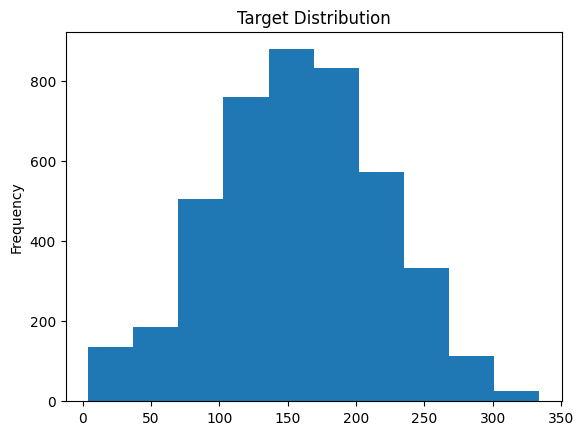

In [11]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [12]:
def get_cat_cols(data):
    # Get the columns with object datatype
    cat_columns=[]
    dummies=[]
    for col in data.columns:
        if data[col].dtype=='object' and 'uid' not in col:
            cat_columns.append(col)
            dummies.append(col)
        elif data[col].dtype!='object' and 'uid' not in col and (data[col].max()==1.0):
            cat_columns.append(col)
            data[col].fillna(0, inplace=True)
        else:
            continue
    return cat_columns, dummies

In [13]:
def encode_cat_cols(train_data, cat_cols, dummy_cols):
    enc = OneHotEncoder()
    enc.fit(train_data[dummy_cols])
    encoded_train_data=enc.transform(train_data[dummy_cols]).toarray()
    feature_names = enc.get_feature_names_out(dummy_cols)
    train_data.drop(columns=dummy_cols, inplace=True)
    encoded_train_df = pd.DataFrame(encoded_train_data, columns=feature_names)
    train_data[feature_names]=encoded_train_df[feature_names]
    return train_data, feature_names

In [14]:
y=merged_df['composite_score']
data_processed=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
cat_cols, dummy_cols = get_cat_cols(data_processed)
data_processed, dummy_feature_names=encode_cat_cols(data_processed, cat_cols, dummy_cols)
data_processed=data_processed.drop(columns=['uid', 'composite_score'],axis=1)

for col in data_processed.columns: 
    if round((data_processed[col].isna().sum() /len(data_processed)*100), 2)>50:
        data_processed.drop(columns=col, inplace=True)
    elif round((data_processed[col].isna().sum() /len(data_processed)*100), 2)>5:
        print(col,round((data_processed[col].isna().sum() /len(data_processed)*100), 2), '% missing')
        data_processed[col].fillna(0, inplace=True)
    else: 
        data_processed[col].fillna(0, inplace=True)
        data_processed[col].fillna(0, inplace=True)

/tmp/ipykernel_955414/53275523.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(0, inplace=True)
/tmp/ipykernel_955414/1296090801.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[feature_names]=encoded_train_df[feature_names]
/tmp/ipykernel_955414/1296090801.py:8:

n_mar_03 33.83 % missing
n_adl_03 33.5 % missing
n_iadl_03 36.99 % missing
n_depr_03 37.1 % missing
n_illnesses_03 33.31 % missing
decis_personal_03 37.17 % missing
n_iadl_12 5.84 % missing
n_depr_12 6.52 % missing
rearnings_03 33.37 % missing
searnings_03 49.98 % missing
hincome_03 34.01 % missing
hinc_business_03 32.98 % missing
hinc_rent_03 32.98 % missing
hinc_assets_03 32.98 % missing
hinc_cap_03 32.98 % missing
rinc_pension_03 33.37 % missing
sinc_pension_03 49.98 % missing
searnings_12 35.19 % missing
sinc_pension_12 35.19 % missing


/tmp/ipykernel_955414/4256840405.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_processed[col].fillna(0, inplace=True)
/tmp/ipykernel_955414/4256840405.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [15]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data=data.drop(columns=['uid','composite_score'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

In [16]:
#separate train and test
merged_df_processed=data_processed[:len(merged_df)]
merged_test_processed=data_processed[len(merged_df):]

In [17]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [18]:
merged_df.shape

(4343, 184)

In [19]:
merged_df_processed.shape

(4343, 377)

In [20]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing results
fold_results = []
optimized_weights_list = []

for train_index, val_index in tqdm(kf.split(merged_df)):
    # Split the data
    train_X, val_X = merged_df.iloc[train_index], merged_df.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]
    
    train_X_processed, val_X_processed = merged_df_processed.iloc[train_index], merged_df_processed.iloc[val_index]

    # Train LightGBM
    train_data = lgb.Dataset(train_X, label=train_y, categorical_feature='auto')
    val_data = lgb.Dataset(val_X, label=val_y, categorical_feature='auto')

    # Define parameters
    params = {
        'objective': 'regression',  # default for regression
        'metric': 'rmse',
        'learning_rate': 0.01,
        'n_estimators': 10000,
        'random_seed': 42
    }

    # Train the model with early stopping
    model1 = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=True),
        ]
    )
    pred1 = model1.predict(val_X, num_iteration=model1.best_iteration)

    # Train CatBoost
    model2 = CatBoostRegressor(
        iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
        cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=100, early_stopping_rounds=500
    )
    model2.fit(train_X, train_y, eval_set=(val_X, val_y))
    pred2 = model2.predict(val_X)
    
    # Train XGBoost
    model3 = XGBRegressor(n_estimators=10000, learning_rate=0.01,
        max_depth=3, random_state=42, 
        enable_categorical=True,
        eval_metric=root_mean_squared_error,
        early_stopping_rounds=500)
    model3.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=100)
    pred3 = model3.predict(val_X)
    
    # Train Random Forest
    model4 = RandomForestRegressor(n_estimators=1000, random_state=42)
    model4.fit(train_X_processed, train_y)
    pred4 = model4.predict(val_X_processed)
    print("RandomForest rmse: ", root_mean_squared_error(val_y, pred4))

    # Define loss function for weight optimization
    def loss_function(weights):
        w1, w2, w3, w4 = weights
        combined_predictions = w1 * pred1 + w2 * pred2 + w3 * pred3 + w4 * pred4
        mse = np.mean((combined_predictions - val_y) ** 2)
        return mse

    # Initial weights
    initial_weights = [1/4, 1/4, 1/4, 1/4]

    # Constraints: weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: w[0] + w[1] + w[2] + w[3] - 1}

    # Bounds: weights must be between 0 and 1
    bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]

    # Optimize weights
    result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)
    optimized_weights = result.x

    # Combine predictions using optimized weights
    final_predictions = (
        optimized_weights[0] * pred1 +
        optimized_weights[1] * pred2 +
        optimized_weights[2] * pred3 +
        optimized_weights[3] * pred4
    )

    # Store results
    fold_mse = root_mean_squared_error(val_y, final_predictions)  # RMSE
    fold_results.append(fold_mse)
    optimized_weights_list.append(optimized_weights)

# Display results
print(f"Average MSE across folds: {np.mean(fold_results)}")
print(f"Optimized weights per fold: {optimized_weights_list}")


0it [00:00, ?it/s]/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 184
[LightGBM] [Info] Start training from score 157.136730
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1492]	valid_0's rmse: 37.0653
0:	learn: 61.0968399	test: 58.8058395	best: 58.8058395 (0)	total: 68.9ms	remaining: 11m 29s
100:	learn: 45.4410279	test: 45.6028066	best: 45.6028066 (100)	total: 2.62s	remaining: 4m 17s
200:	learn: 39.0878675	test: 41.5456612	best: 41.5456612 (200)	total: 5.98s	remaining: 4m 51s
300:	learn: 35.5986901	test: 39.9273411	best: 39.9273411 (300)	total: 9.37s	remaining: 5m 2s
400:	learn: 33.2094891	test: 39.1314163	best: 39.1314163 (400)	total: 12.4s	remaining: 4m 5

1it [06:49, 409.97s/it]

RandomForest rmse:  37.167595311963325
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1558
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 184
[LightGBM] [Info] Start training from score 157.271445
Training until validation scores don't improve for 500 rounds


/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1278]	valid_0's rmse: 36.2766
0:	learn: 59.9979103	test: 63.2095608	best: 63.2095608 (0)	total: 92.2ms	remaining: 15m 21s
100:	learn: 45.1486532	test: 47.5175717	best: 47.5175717 (100)	total: 2.57s	remaining: 4m 11s
200:	learn: 39.0906320	test: 42.2019668	best: 42.2019668 (200)	total: 5.49s	remaining: 4m 27s
300:	learn: 35.7810579	test: 40.0875359	best: 40.0875359 (300)	total: 8.41s	remaining: 4m 30s
400:	learn: 33.4582687	test: 39.0410680	best: 39.0410680 (400)	total: 11.3s	remaining: 4m 31s
500:	learn: 31.8339698	test: 38.4222289	best: 38.4222289 (500)	total: 14.3s	remaining: 4m 30s
600:	learn: 30.4534694	test: 38.0403618	best: 38.0403618 (600)	total: 17.1s	remaining: 4m 27s
700:	learn: 29.4400671	test: 37.8087585	best: 37.8087585 (700)	total: 20.1s	remaining: 4m 25s
800:	learn: 28.4904281	test: 37.6239716	best: 37.6239716 (800)	total: 22.8s	remaining: 4m 21s
900:	learn: 27.5077689	test: 37.4530028	best: 37.4530028 (900)	total: 25.9s	remaining: 4m 

2it [12:12, 358.64s/it]

RandomForest rmse:  37.0849290685524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 184
[LightGBM] [Info] Start training from score 156.375360
Training until validation scores don't improve for 500 rounds


/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[2365]	valid_0's rmse: 38.977
0:	learn: 60.9011270	test: 59.6063548	best: 59.6063548 (0)	total: 23.2ms	remaining: 3m 51s
100:	learn: 45.0866310	test: 46.6020960	best: 46.6020960 (100)	total: 2.51s	remaining: 4m 6s
200:	learn: 38.8123756	test: 42.7566805	best: 42.7566805 (200)	total: 5.39s	remaining: 4m 22s
300:	learn: 35.1670499	test: 41.0863368	best: 41.0863368 (300)	total: 8.45s	remaining: 4m 32s
400:	learn: 32.7953003	test: 40.3183533	best: 40.3183533 (400)	total: 11.4s	remaining: 4m 32s
500:	learn: 31.0434299	test: 39.8397078	best: 39.8397078 (500)	total: 14.4s	remaining: 4m 33s
600:	learn: 29.7852070	test: 39.5566473	best: 39.5566473 (600)	total: 17.4s	remaining: 4m 31s
700:	learn: 28.7523588	test: 39.3672862	best: 39.3672862 (700)	total: 20.2s	remaining: 4m 28s
800:	learn: 27.7153668	test: 39.1789621	best: 39.1789621 (800)	total: 23.2s	remaining: 4m 25s
900:	learn: 26.8477939	test: 39.0294404	best: 39.0284130 (898)	total: 26.3s	remaining: 4m 25s

3it [17:26, 338.14s/it]

RandomForest rmse:  39.2325107880024
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 3475, number of used features: 184
[LightGBM] [Info] Start training from score 157.237122
Training until validation scores don't improve for 500 rounds


/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[3242]	valid_0's rmse: 36.4052
0:	learn: 60.6014303	test: 60.7946485	best: 60.7946485 (0)	total: 26.2ms	remaining: 4m 22s
100:	learn: 45.1270455	test: 46.8539846	best: 46.8539846 (100)	total: 2.43s	remaining: 3m 58s
200:	learn: 38.8983723	test: 42.3812053	best: 42.3812053 (200)	total: 5.45s	remaining: 4m 25s
300:	learn: 35.4510649	test: 40.6666022	best: 40.6666022 (300)	total: 8.46s	remaining: 4m 32s
400:	learn: 33.2082143	test: 39.8262530	best: 39.8262530 (400)	total: 11.4s	remaining: 4m 32s
500:	learn: 31.5916940	test: 39.3422105	best: 39.3422105 (500)	total: 14.3s	remaining: 4m 30s
600:	learn: 30.3353372	test: 39.0297971	best: 39.0297971 (600)	total: 17.3s	remaining: 4m 30s
700:	learn: 29.1521855	test: 38.7589983	best: 38.7589983 (700)	total: 20.3s	remaining: 4m 28s
800:	learn: 28.0347992	test: 38.5510221	best: 38.5510221 (800)	total: 23.2s	remaining: 4m 26s
900:	learn: 27.1562471	test: 38.3687485	best: 38.3687485 (900)	total: 26.4s	remaining: 4m 2

4it [24:38, 375.08s/it]

RandomForest rmse:  37.84536545958547
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 3475, number of used features: 184
[LightGBM] [Info] Start training from score 157.063309
Training until validation scores don't improve for 500 rounds


/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1889]	valid_0's rmse: 40.4176
0:	learn: 60.6063864	test: 60.8112299	best: 60.8112299 (0)	total: 23.3ms	remaining: 3m 53s
100:	learn: 44.6720446	test: 47.5307961	best: 47.5307961 (100)	total: 2.51s	remaining: 4m 6s
200:	learn: 38.3069288	test: 43.9226278	best: 43.9226278 (200)	total: 5.49s	remaining: 4m 27s
300:	learn: 34.8000820	test: 42.5284960	best: 42.5284960 (300)	total: 8.59s	remaining: 4m 36s
400:	learn: 32.6221258	test: 41.9003158	best: 41.9003158 (400)	total: 11.6s	remaining: 4m 38s
500:	learn: 31.0140313	test: 41.4877224	best: 41.4877224 (500)	total: 14.5s	remaining: 4m 35s
600:	learn: 29.6661111	test: 41.2052206	best: 41.2052206 (600)	total: 17.4s	remaining: 4m 31s
700:	learn: 28.4412860	test: 40.9896129	best: 40.9896129 (700)	total: 20.4s	remaining: 4m 30s
800:	learn: 27.3865312	test: 40.8010040	best: 40.8010040 (800)	total: 23.4s	remaining: 4m 28s
900:	learn: 26.3695772	test: 40.6661726	best: 40.6661726 (900)	total: 26.6s	remaining: 4m 28

5it [31:18, 375.60s/it]

RandomForest rmse:  40.62677968525773
Average MSE across folds: 37.09901391322352
Optimized weights per fold: [array([0.00970546, 0.48701967, 0.24999563, 0.25327923]), array([0.32447771, 0.47947732, 0.10986934, 0.08617563]), array([0.08375916, 0.87731506, 0.02437395, 0.01455183]), array([5.54591421e-01, 3.24937521e-01, 1.20471059e-01, 3.73565809e-13]), array([5.51754103e-18, 6.24163289e-01, 2.50116089e-01, 1.25720622e-01])]


In [21]:
print(f"Average MSE across folds: {np.mean(fold_results)}")

Average MSE across folds: 37.09901391322352


In [22]:
np.mean(optimized_weights_list, axis=0)

array([0.19450675, 0.55858257, 0.15096522, 0.09594546])

In [23]:
# Calculate the average weights from cross-validation
average_weights = np.mean(optimized_weights_list, axis=0)

# Train models on the entire training dataset
train_data = lgb.Dataset(merged_df, label=y, categorical_feature='auto')

params = {
    'objective': 'regression',  # default for regression
    'metric': 'rmse',
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'random_seed': 42
}
final_model1 = lgb.train(
    params,
    train_data
)

final_model2 = CatBoostRegressor(
    iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    verbose=100
)
final_model2.fit(merged_df, y)

final_model3 = XGBRegressor(n_estimators=10000, learning_rate=0.01,
        max_depth=3, random_state=42, 
        enable_categorical=True,
        eval_metric=root_mean_squared_error)
final_model3.fit(merged_df, y)

# Train Random Forest
final_model4 = RandomForestRegressor(n_estimators=1000, random_state=42)
final_model4.fit(merged_df_processed, y)

# Generate predictions on the test dataset
test_pred1 = final_model1.predict(merged_test)
test_pred2 = final_model2.predict(merged_test)
test_pred3 = final_model3.predict(merged_test)
test_pred4 = final_model4.predict(merged_test_processed)

# Combine the predictions using the average weights
final_test_predictions = (
    average_weights[0] * test_pred1 + average_weights[1] * test_pred2 + average_weights[2] * test_pred3 + average_weights[3] * test_pred4
)

# Optionally round predictions if required (e.g., for classification tasks)
final_test_predictions = np.round(final_test_predictions).astype(int)

# Display final predictions
print("Final blended predictions for the test dataset:")
print(final_test_predictions)

ss['composite_score']=final_test_predictions
#generate submission
ss.to_csv('dataset/LGBM_and_CatBoost_and_XGBoost_RandomForest.csv', index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1653
[LightGBM] [Info] Number of data points in the train set: 4343, number of used features: 184
[LightGBM] [Info] Start training from score 157.016809


/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


0:	learn: 60.6445520	total: 13.2ms	remaining: 2m 11s
100:	learn: 45.0332493	total: 2.51s	remaining: 4m 6s
200:	learn: 38.9044928	total: 5.5s	remaining: 4m 28s
300:	learn: 35.5399273	total: 8.57s	remaining: 4m 36s
400:	learn: 33.3917089	total: 11.5s	remaining: 4m 35s
500:	learn: 31.8994396	total: 14.4s	remaining: 4m 33s
600:	learn: 30.7114954	total: 17.4s	remaining: 4m 32s
700:	learn: 29.6846195	total: 20.7s	remaining: 4m 34s
800:	learn: 28.8254993	total: 23.7s	remaining: 4m 32s
900:	learn: 27.9642830	total: 26.9s	remaining: 4m 31s
1000:	learn: 27.1063650	total: 30.3s	remaining: 4m 32s
1100:	learn: 26.4289151	total: 33.7s	remaining: 4m 32s
1200:	learn: 25.7500371	total: 37s	remaining: 4m 31s
1300:	learn: 25.0498635	total: 40.3s	remaining: 4m 29s
1400:	learn: 24.4402644	total: 43.7s	remaining: 4m 27s
1500:	learn: 23.9600868	total: 47.1s	remaining: 4m 26s
1600:	learn: 23.4730841	total: 50.6s	remaining: 4m 25s
1700:	learn: 23.0239954	total: 54.1s	remaining: 4m 23s
1800:	learn: 22.5589787	t